In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, sys
sys.path.insert(0, '../scripts')

from fc_helpers import make_corrfig, linearize, get_flat_inds_for_net, triangularizeweights, get_flat_inds_for_block
from data_loader import data_loader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import svm
import itertools
from group_lasso import LogisticGroupLasso

In [2]:
demo = pd.read_csv('../data/demo.csv', names=['VC', 'Age', 'Group'])

demo_ts = demo.where(demo.Group=='TS').dropna().reset_index(drop=True)
demo_hc = demo.where(demo.Group=='TFC').dropna().reset_index(drop=True)

In [3]:
# custom data loader reads in connectivity data for each group seperately
ts_con = data_loader(demo_ts)
hc_con = data_loader(demo_hc)

# Connectivity matricies are symettric and square. We need just the flattened upper or lower triangle, of the matrix
# to create a new design matrix

ts_con_flat = linearize(ts_con)
hc_con_flat = linearize(hc_con)


# create feature matrix
X = np.vstack((hc_con_flat, ts_con_flat))

# create label vector: 1 for HC, -1 for TS
y = np.concatenate((np.repeat(1,99), np.repeat(-1,99)))

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

In [4]:
# Define feature groups for use in Group lasso

np.random.seed(0)
LogisticGroupLasso.LOG_LOSSES = True
groups = np.repeat(-99,62128)
names_abbrev = ['Auditory','CingOperc','CingPar','Default','DorsalAtt','FrontoPar','None',
        'RetroTemp','Salience','SMhand','SMmouth','VentralAtt','Visual','Subcort']
combos = list(itertools.combinations_with_replacement(names_abbrev, 2))

all_block_inds = []

for net1, net2 in combos:
    inds = get_flat_inds_for_block(net1,net2)
    all_block_inds.append(inds)
    
for i,block in enumerate(all_block_inds):
    groups[list(block)] = i

In [5]:
# Train and visualize chosen groups

gl = LogisticGroupLasso(
    groups=groups,
    group_reg=4,
    l1_reg=0,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=1000,
    tol=1e-3,
    warm_start=True,  # Warm start to start each subsequent fit with previous weights

)

gl.fit(X_scale, y)

/Users/matt/anaconda3/lib/python3.7/site-packages/group_lasso/_group_lasso.py:839: UserWarning: Subsampling is not stable for logistic regression group lasso.
  "Subsampling is not stable for logistic regression group lasso."


LogisticGroupLasso(group_reg=4,
                   groups=array([  0,   0,   0, ..., 104, 104, 104]), l1_reg=0,
                   n_iter=1000, scale_reg='inverse_group_size',
                   subsampling_scheme=1, supress_warning=True, tol=0.001,
                   warm_start=True)

Number variables: 62128
Number of chosen variables: 10321
Accuracy: 1.0


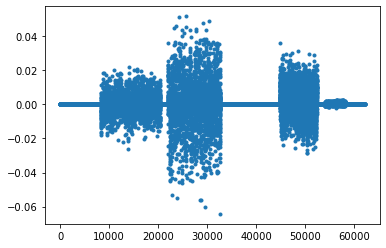

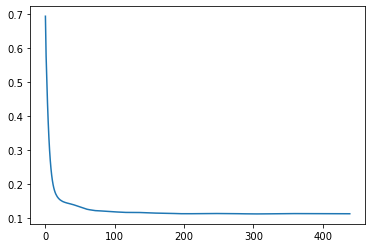

In [6]:
# Extract info from estimator
pred_c = gl.predict(X_scale)
sparsity_mask = gl.sparsity_mask_
w_hat = gl.coef_

# Compute performance metrics
accuracy = np.mean(pred_c == y)

# Print results
print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"Accuracy: {accuracy}")
coef = gl.coef_[:, 1] - gl.coef_[:, 0]
plt.figure()
plt.plot(coef / np.linalg.norm(coef), ".", label="Estimated weights")

plt.figure()
plt.plot(gl.losses_)

plt.show()

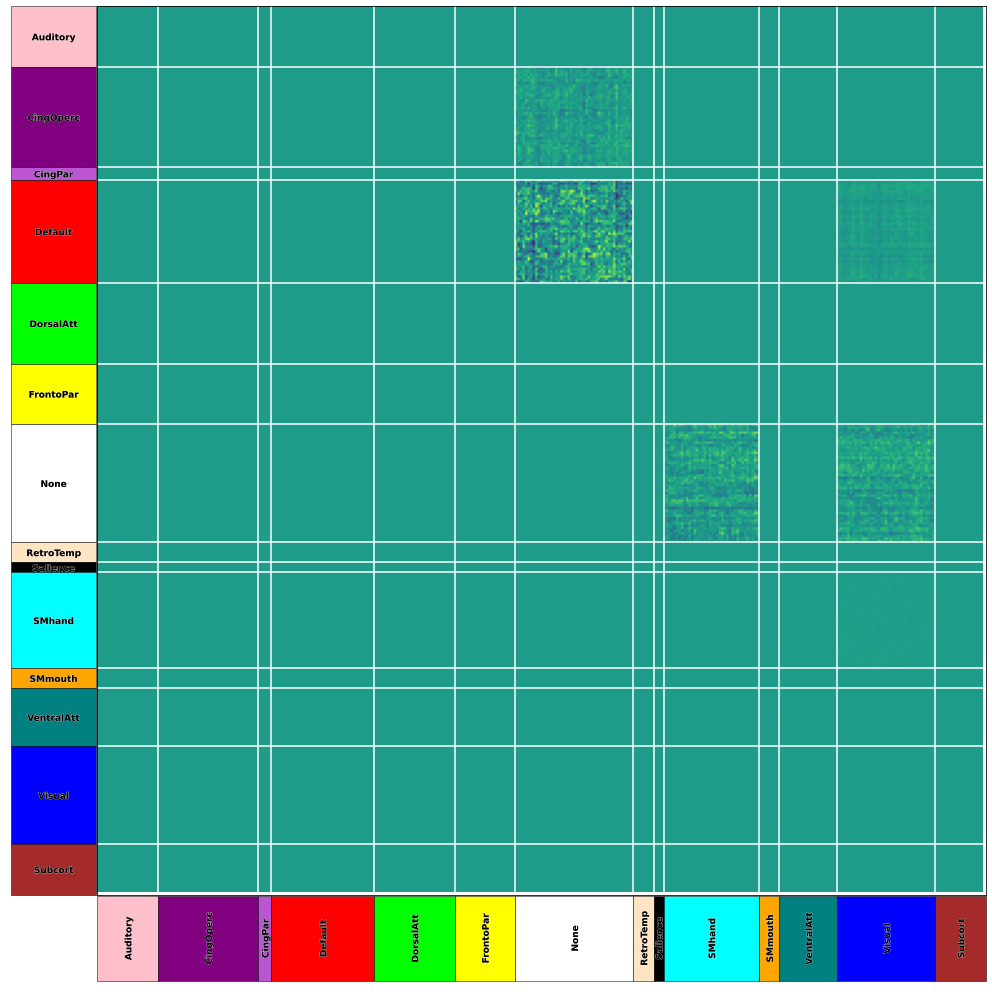

In [7]:
make_corrfig(triangularizeweights(coef),weights=True)

In [ ]:

# none_inds = get_flat_inds_for_net('None')
# none_inds.shape
# groups[none_inds] = 105
# X_scale_nets = np.copy(X_scale)
# X_scale_nets[:,none_inds] = 0

# regularisations = np.logspace(-0.5, 1.5, 10)
# regularisations

# cv = LeaveOneOut()
# clf = gl

# scores = cross_val_score(clf,X_scale_nets,y, scoring='accuracy', cv=cv, n_jobs=-3)
# print('LOOCV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))